## Demonstration of NetworkUnit
#### Comparing model implementation (C vs. SpiNNaker) and experimental data (monkey L vs. monkey N)

add Intro and concept of NetworkUnit (figure)

In [1]:
ls

demonstrate_M2M_X2X.ipynb  network_validation/


<div style='float:left; width:50%; display:inline-block'>
    <img src="../figures/validation_environment.png" width="100%" />
</div>
<div style='float:right; text-align:left; width:50%; display:inline-block'>
    <p>Validation: Quantitative evaluation of usefulness and accuracy</p>
</div>

concept of networkunit

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/flowchart.png" width="100%" />
</div>

explain M2M

<div style='width:50%; display:block; margin-left:auto; margin-right:auto'>
        <img src="../figures/flowchart_M2M.png" width="100%" />
</div>

In [1]:
%matplotlib inline
import sys
import os
import sciunit
import elephant
import numpy as np
from quantities import ms
from neo.core import SpikeTrain
from copy import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
import warnings
warnings.filterwarnings('ignore')

In [3]:
# How to add NetworkUnit to other projects

# !git clone https://github.com/INM-6/NetworkUnit.git
# !cd NetworkUnit/; git fetch; git pull

# sys.path.insert(0, './NetworkUnit')

In [38]:
# sys.path.insert(0, 'path/to/networkunit')
sys.path.insert(0, '../')
from networkunit import models, tests, scores, plots

AttributeError: 'list' object has no attribute 'instert'

### Validating a SpiNNaker simulation against a C simulation
This comparison uses model implementation of a polychronization network model (Izhikevich, 2006)

In [5]:
# Clone gin repository 
!git clone git@gin.g-node.org:/INM-6/network_validation.git

# load simulation data
os.chdir('./network_validation')
!git-annex get ./simulation_data/iteration_III/60s_simulation_runs/*/out_firings_after5h.dat
os.chdir('..')

fatal: destination path 'network_validation' already exists and is not an empty directory.


#### Define the poychronyzation model class

In [6]:
class polychrony_data(models.spiketrain_data):
    file_path = '' # to be added in child class
    
    params = {'align_to_0': True,
              'filter_inh': True,
             }
    
    def load(self, file_path, simulator, t_start=0, t_stop=60000, filter_inh=False, **kwargs):
        f = open(file_path, 'r')
        lines = f.readlines()
        
        N = 1000 # neurons 
        
        # Read Spike Times
        spike_times = [[]] * N
        for line in lines:
            sec, msec, n = line.split(' ')[:3]
            t = float(sec)*1000. + float(msec)
            n = int(n)
            if t > t_stop:
                break
            spike_times[n] = spike_times[n] + [t]

        # Fill Spike Trains
        nbr_neurons = N
        if filter_inh:
            nbr_neurons = 800
            
        spiketrains = [[]] * nbr_neurons

        for n, st in enumerate(spike_times):
            if n < 800:
                n_type = 'exc'
            else:
                n_type = 'inh'
            if not filter_inh or n_type == 'exc':
                spiketrains[n] = SpikeTrain(np.sort(st), units='ms', 
                                            t_start=t_start, t_stop=t_stop,
                                            n_type=n_type, unitID=n)
        return spiketrains

#### Define the model classes of the simulators as child classes

In [7]:
# C simulation
class C_sim(polychrony_data):
    file_path = './network_validation/simulation_data/iteration_III/60s_simulation_runs/C/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
# SpiNNaker simulation    
class S_sim(polychrony_data):
    file_path = './network_validation/simulation_data/iteration_III/60s_simulation_runs/SpiNNaker/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')

In [8]:
C = C_sim(name='C')
S = S_sim(name='SpiNNaker')

#### Show the rasterplots

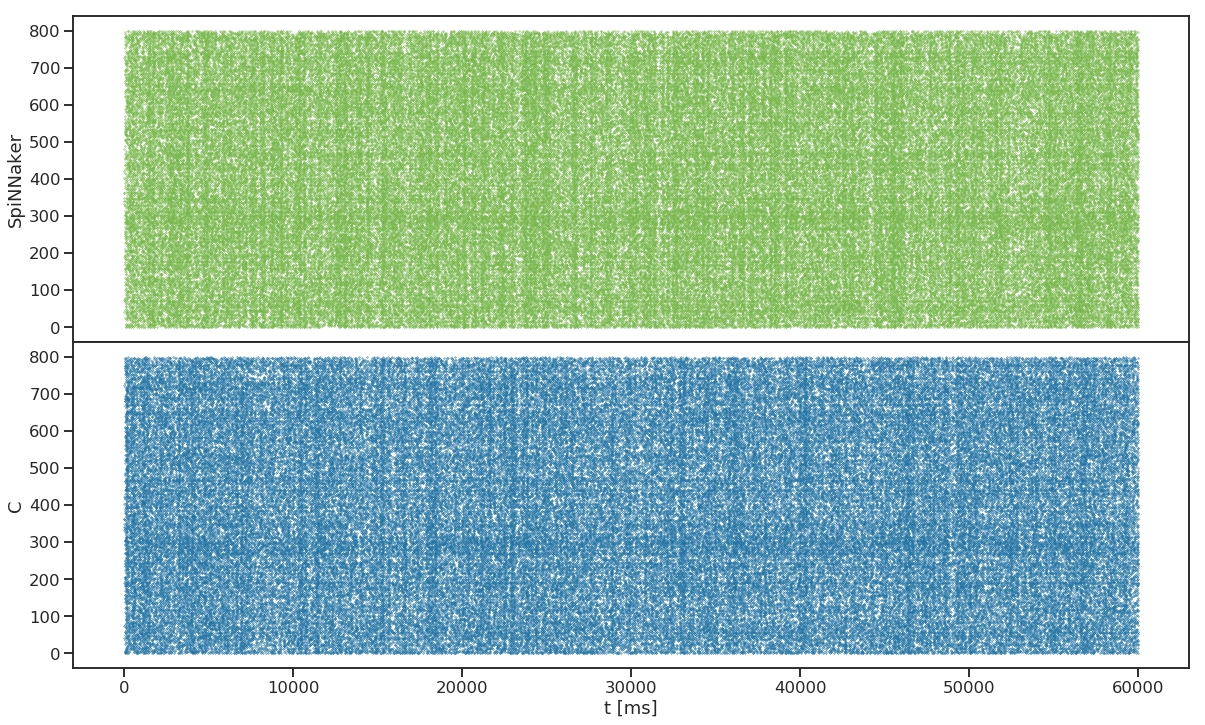

In [10]:
fig, ax = plt.subplots(nrows=2, sharex=True, 
                       gridspec_kw={'hspace':0}, 
                       figsize=(20,12))

for sim_count, sim in enumerate([S, C]):
    sim.produce_spiketrains()
    for st_count, st in enumerate(sim.spiketrains):
        ax[sim_count].scatter(st, [st_count]*len(st), 
                              color=sim.params['color'], 
                              marker='.', s=1)
        
    ax[sim_count].set_ylabel(sim.name)
ax[-1].set_xlabel('t [ms]');

#### Define a test class

In [17]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size
    
class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}
    
FR_test = FR_test_class()
LV_test = LV_test_class()

#### How a test works

In [18]:
# every test has a function generate_prediction() 
# which calculates the test measure
FR_test.generate_prediction(C)

[array(2.41666667) * Hz,
 array(2.85) * Hz,
 array(3.1) * Hz,
 array(3.63333333) * Hz,
 array(2.5) * Hz,
 array(2.51666667) * Hz,
 array(2.53333333) * Hz,
 array(4.75) * Hz,
 array(1.83333333) * Hz,
 array(2.76666667) * Hz,
 array(1.91666667) * Hz,
 array(2.73333333) * Hz,
 array(1.76666667) * Hz,
 array(3.73333333) * Hz,
 array(2.56666667) * Hz,
 array(2.03333333) * Hz,
 array(2.5) * Hz,
 array(2.65) * Hz,
 array(2.31666667) * Hz,
 array(2.93333333) * Hz,
 array(2.1) * Hz,
 array(1.83333333) * Hz,
 array(2.26666667) * Hz,
 array(3.06666667) * Hz,
 array(3.7) * Hz,
 array(2.25) * Hz,
 array(4.71666667) * Hz,
 array(2.58333333) * Hz,
 array(1.46666667) * Hz,
 array(3.03333333) * Hz,
 array(1.1) * Hz,
 array(2.58333333) * Hz,
 array(3.36666667) * Hz,
 array(2.68333333) * Hz,
 array(1.9) * Hz,
 array(1.86666667) * Hz,
 array(2.76666667) * Hz,
 array(3.01666667) * Hz,
 array(3.2) * Hz,
 array(2.08333333) * Hz,
 array(2.6) * Hz,
 array(3.16666667) * Hz,
 array(2.83333333) * Hz,
 array(3.3) 

#### the test is also able to visualize the measure samples

No handles with labels found to put in legend.


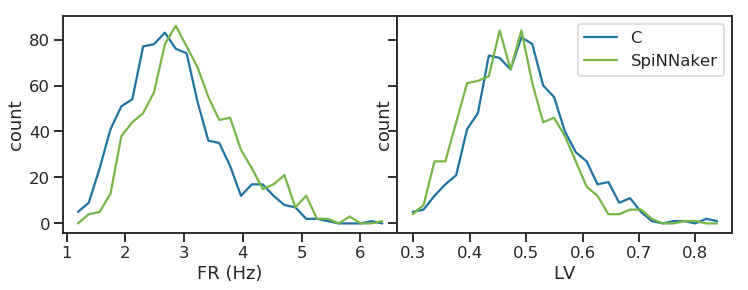

In [36]:
fig, ax = plt.subplots(ncols=2, sharey=True, gridspec_kw={'wspace':0}, figsize=(12,4))

FR_test.visualize_samples(C, S, ax=ax[0], var_name='FR (Hz)', bins=30, density=False)
LV_test.visualize_samples(C, S, ax=ax[1], var_name='LV', bins=30, density=False)

#### to perform the actual validation and calculate a test score, you call the judge() function
judge() will
    1. check if the model has all the required capabilities.
    2. call generate_prediction()
    3. call compute_score()
    4. check that the score is of score_type
    5. equip the score with metadata
    6. returns the score.

In [31]:
# For a model-to-model test the two models are passed as a list\
print('FR test:\n', FR_test.judge([C, S]).score, '\n')
print('LV test:\n', LV_test.judge([C, S]).score)

'FR test:\n'

,C,SpiNNaker
C,0.000000,0.394106
SpiNNaker,0.394106,0.000000


'\n'

LV test:
                  C  SpiNNaker
C          0.00000    0.27085
SpiNNaker  0.27085    0.00000


In [21]:
# to access an element of the score DataFrame use
print(FR_test.judge([C, S]).iloc[1,0])
# print of a score instance invokes the __str__ property of the test



Effect Size
	datasize: 800 	 800
	Effect Size = 0.394 	 CI = (0.295, 0.493)




#### Using a different statistical test as score type is as simple as

In [37]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.ks_distance

FR_test = FR_test_class()

print(FR_test.judge([C, S]).iloc[1,0])



Kolmogorov-Smirnov-Distance
	datasize: 800 	 800
	D_KS = 0.185 	 p value = 1.82e-12




#### That's good and fine but what about experimental data !?!?!?

In [ ]:
# Clone repository (this will not download large data files)
!gin get doi/multielectrode_grasp

# download large data files needed for this example
os.chdir('./multielectrode_grasp')
!gin get-content ./datasets/l101210-001.odml # metadata for monkey L
!gin get-content ./datasets/l101210-001.ns2 # analog signals for monkey L
!gin get-content ./datasets/l101210-001.ccf
!gin get-content ./datasets/l101210-001.nev # unsorted spike times for monkey L
!gin get-content ./datasets/l101210-001-02.nev # sorted spike times for monkey L
!gin get-content ./datasets/i140703-001.odml # metadata for monkey I
!gin get-content ./datasets/i140703-001.ns2 # analog signals monkey I
!gin get-content ./datasets/i140703-001.ccf
!gin get-content ./datasets/i140703-001.nev # unsorted spike times for monkey I
!gin get-content ./datasets/i140703-001-03.nev # sorted spike times for monkey I
os.chdir('..')

# add to path
sys.path.insert(0, './multielectrode_grasp/code/python-neo')
sys.path.insert(0, './multielectrode_grasp/code/python-odml')
sys.path.insert(0, './multielectrode_grasp/code/reachgraspio')
sys.path.insert(0, './multielectrode_grasp/code')

<p><i>"A model, like a novel, may resonate with nature, but it is not a 'real' thing. Like novel, a model may be convinving - it may 'ring true' if it is consistent with our experience of the natural world. But just as we may wonder how much the characters in a novel are drawn from real life and how much is artifice, we might ask the same of a model: How much is based on observation and measurement of accesssible phenomena, how much is based on informed judgment, and how much is convencience?"</i></p>
<p style="float:right">Orsekes, 1994</p>
